In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from pylab import *
import copy
import time

torch.manual_seed(1)                      # reproducible
torch.set_printoptions(threshold=np.inf)  # print all


# ----- Step 1: Set Hyper Parameters ----- #

model = 'LSTM'
dataset = 'DistalPhalanxOutlineAgeGroup'
NAME = f'{model}-UCR-{dataset}'

train_data_path = f'../Datasets/UCR/{dataset}/{dataset}_TRAIN.tsv'
test_data_path = f'../Datasets/UCR/{dataset}/{dataset}_TEST.tsv'

BATCH_SIZE = 200  # 150
LR = 0.001

TIME_STEP = 80
INPUT_SIZE = 1
OUTPUT_SIZE = 3


# ----- Step 2: Dataset Loading and Preprocessing ----- #

class GetLoader(torch.utils.data.Dataset):      # 定义GetLoader类，继承Dataset方法

    def __init__(self, data_root, data_label):  # 初始化，加载数据
        self.data = data_root
        self.label = data_label

    def __getitem__(self, index):               # index是根据batchsize划分数据得到的索引
        data = self.data[index]
        labels = self.label[index]
        return data, labels

    def __len__(self):                          # 返回数据大小长度，方便DataLoader划分
        return len(self.data)

    
train_text = ''
test_text = ''

train_x = []
train_y = []
test_x = []
test_y = []

with open(train_data_path, 'r') as f:
    train_text = f.read()
train_lines = train_text.split('\n')
for line in train_lines:
    _list = line.split('\t')
    if len(_list) > 1:
        train_y.append(float(_list[0])-1)
        flo_list = [[float(num)] for num in _list[1:]]
        train_x.append(flo_list)

with open(test_data_path, 'r') as f:
    test_text = f.read()
test_lines = test_text.split('\n')
for line in test_lines:
    _list = line.split('\t')
    if len(_list) > 1:
        test_y.append(float(_list[0])-1)
        flo_list = [[float(num)] for num in _list[1:]]
        test_x.append(flo_list)
        
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

for i in range(len(train_y)):  # special pre-processing bacause of the format of the original dataset
    if train_y[i] == -1:
        train_y[i] = 1
        
for i in range(len(test_y)):
    if test_y[i] == -1:
        test_y[i] = 1

print('*** Dataset Information ***\ntrain_x:', train_x.shape, '\ntrain_y:', train_y.shape, '\ntest_x:', test_x.shape, '\ntest_y:', test_y.shape)


# 留作每50轮输出当前训练结果用
train_X = copy.deepcopy(train_x)
train_X = torch.from_numpy(train_X).to(torch.float32)
train_Y = copy.deepcopy(train_y)
test_X = torch.from_numpy(test_x).to(torch.float32)
test_Y = test_y

train_x = torch.from_numpy(train_x).to(torch.float32)
train_y = torch.from_numpy(train_y).to(torch.long)
train_data = GetLoader(train_x, train_y)                # 返回Dataset对象(包含data和label)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

train_Y1 = copy.deepcopy(train_y)


# ----- Step 3: Create Model Class ----- #

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=128,
            num_layers=2,
            batch_first=True
        )
        self.out = nn.Linear(128, OUTPUT_SIZE)

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)  # None represents zero initial hidden state
        out = self.out(r_out[:, -1, :])        # choose r_out at the last time step
        out_trace = self.out(r_out)            # choose r_out at all time steps
        return out, out_trace


# ----- Step 4: Instantiate ----- #

rnn = RNN()
print('\n*** Model Information ***\n', rnn, '\n\n*** Training Information ***')

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()   # the target label is not one-hotted


# ----- Step 5: Model Training ----- #

for turns in range(1, 201):
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        
        train_x = train_x.view(-1, TIME_STEP, INPUT_SIZE)
        output, _ = rnn(train_x)
        loss = loss_fn(output, train_y)
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()        # backward and compute gradients
        optimizer.step()       # apply gradients

        train_output, _ = rnn(train_X)
        pred_train_y = torch.max(train_output, 1)[1].data.numpy()
        train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
        train_loss = loss_fn(train_output, train_Y1)

        torch.save(rnn, f'../Models/{NAME}/epoch_{turns}_{batch_idx}.pkl')
        print('Epoch: ', turns, '_', batch_idx, '| train loss: %.4f' % train_loss.data.numpy(), '| train accuracy: %.2f' % train_accuracy)


*** Dataset Information ***
train_x: (400, 80, 1) 
train_y: (400,) 
test_x: (139, 80, 1) 
test_y: (139,)

*** Model Information ***
 RNN(
  (rnn): LSTM(1, 128, num_layers=2, batch_first=True)
  (out): Linear(in_features=128, out_features=3, bias=True)
) 

*** Training Information ***
Epoch:  1 _ 0 | train loss: 1.0991 | train accuracy: 0.07
Epoch:  1 _ 1 | train loss: 1.0802 | train accuracy: 0.64
Epoch:  2 _ 0 | train loss: 1.0605 | train accuracy: 0.64
Epoch:  2 _ 1 | train loss: 1.0388 | train accuracy: 0.64
Epoch:  3 _ 0 | train loss: 1.0139 | train accuracy: 0.64
Epoch:  3 _ 1 | train loss: 0.9842 | train accuracy: 0.64
Epoch:  4 _ 0 | train loss: 0.9481 | train accuracy: 0.64
Epoch:  4 _ 1 | train loss: 0.9051 | train accuracy: 0.64
Epoch:  5 _ 0 | train loss: 0.8592 | train accuracy: 0.64
Epoch:  5 _ 1 | train loss: 0.8381 | train accuracy: 0.64
Epoch:  6 _ 0 | train loss: 0.8699 | train accuracy: 0.64
Epoch:  6 _ 1 | train loss: 0.8729 | train accuracy: 0.64
Epoch:  7 _ 0 | tra

Epoch:  68 _ 1 | train loss: 0.3817 | train accuracy: 0.85
Epoch:  69 _ 0 | train loss: 0.3741 | train accuracy: 0.84
Epoch:  69 _ 1 | train loss: 0.3815 | train accuracy: 0.84
Epoch:  70 _ 0 | train loss: 0.3769 | train accuracy: 0.84
Epoch:  70 _ 1 | train loss: 0.3716 | train accuracy: 0.84
Epoch:  71 _ 0 | train loss: 0.3725 | train accuracy: 0.85
Epoch:  71 _ 1 | train loss: 0.3740 | train accuracy: 0.85
Epoch:  72 _ 0 | train loss: 0.3705 | train accuracy: 0.84
Epoch:  72 _ 1 | train loss: 0.3704 | train accuracy: 0.84
Epoch:  73 _ 0 | train loss: 0.3691 | train accuracy: 0.84
Epoch:  73 _ 1 | train loss: 0.3684 | train accuracy: 0.84
Epoch:  74 _ 0 | train loss: 0.3684 | train accuracy: 0.84
Epoch:  74 _ 1 | train loss: 0.3675 | train accuracy: 0.84
Epoch:  75 _ 0 | train loss: 0.3685 | train accuracy: 0.85
Epoch:  75 _ 1 | train loss: 0.3669 | train accuracy: 0.85
Epoch:  76 _ 0 | train loss: 0.3664 | train accuracy: 0.84
Epoch:  76 _ 1 | train loss: 0.3662 | train accuracy: 0.

Epoch:  137 _ 1 | train loss: 0.3316 | train accuracy: 0.85
Epoch:  138 _ 0 | train loss: 0.3653 | train accuracy: 0.85
Epoch:  138 _ 1 | train loss: 0.3460 | train accuracy: 0.85
Epoch:  139 _ 0 | train loss: 0.3800 | train accuracy: 0.83
Epoch:  139 _ 1 | train loss: 0.3908 | train accuracy: 0.83
Epoch:  140 _ 0 | train loss: 0.3688 | train accuracy: 0.84
Epoch:  140 _ 1 | train loss: 0.3542 | train accuracy: 0.85
Epoch:  141 _ 0 | train loss: 0.3557 | train accuracy: 0.85
Epoch:  141 _ 1 | train loss: 0.3590 | train accuracy: 0.85
Epoch:  142 _ 0 | train loss: 0.3549 | train accuracy: 0.85
Epoch:  142 _ 1 | train loss: 0.3504 | train accuracy: 0.85
Epoch:  143 _ 0 | train loss: 0.3515 | train accuracy: 0.86
Epoch:  143 _ 1 | train loss: 0.3561 | train accuracy: 0.85
Epoch:  144 _ 0 | train loss: 0.3580 | train accuracy: 0.85
Epoch:  144 _ 1 | train loss: 0.3495 | train accuracy: 0.85
Epoch:  145 _ 0 | train loss: 0.3474 | train accuracy: 0.86
Epoch:  145 _ 1 | train loss: 0.3577 | t

In [2]:
"""
Finding The Optimum Model Automatically

"""

min_loss = 10000
max_test_acc = 0
corresponding_train_acc = 0

turns_chosen = -1
batch_idx_chosen = -1

for turns in range(1, 201):
    batch_number = int(train_X.shape[0]/BATCH_SIZE)
    if train_X.shape[0] % BATCH_SIZE != 0:
        batch_number += 1
    
    for batch_idx in range(batch_number):
        rnn = torch.load(f'../Models/{NAME}/epoch_{turns}_{batch_idx}.pkl')
        
        train_output, _ = rnn(train_X)
        pred_train_y = torch.max(train_output, 1)[1].data.numpy()
        train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
        train_loss = loss_fn(train_output, train_Y1)
        
        test_output, _ = rnn(test_X)
        pred_test_y = torch.max(test_output, 1)[1].data.numpy()
        test_accuracy = float((pred_test_y == test_Y).astype(int).sum()) / float(test_Y.size)
        
        test_acc_bias = test_accuracy - max_test_acc
        loss_bias = train_loss.data.numpy() - min_loss
        if test_acc_bias >= 0.01 or (test_acc_bias >= 0 and test_acc_bias < 0.01 and loss_bias < 0.1):
            max_test_acc = test_accuracy
            min_loss = train_loss.data.numpy()
            corresponding_train_acc = train_accuracy
            turns_chosen = turns
            batch_idx_chosen = batch_idx

print('*** The Optimum Model ***\nEpoch Index: ', turns_chosen, '_', batch_idx_chosen)
print('Train Loss: %.6f' % min_loss, '\nTrain Accuracy: %.4f' % corresponding_train_acc, '\nTest Accuracy: %.4f' % max_test_acc)


*** The Optimum Model ***
Epoch Index:  199 _ 0
Train Loss: 0.315647 
Train Accuracy: 0.8525 
Test Accuracy: 0.7842


In [3]:
"""
 *** RNN - WFA Extraction ***

"""

def findByRow(mat, row):
    return np.where((mat == row).all(1))[0]


# Set Hyper-parameter of WFA Establishment
T = 30
INPUT_DISTANCE_FACTOR = 0.07  # value range: (0,1], divide tokens in the content that grading size is micro compared with average distance

if OUTPUT_SIZE >= 3:
    K = 3
else:
    K = 2


# ----- Step 1: Input Tokens Abstraction ----- #
print(f"*** Step 1: Input Tokens Abstraction ***")

# Getting Normalized Alphabet
train_X_numpy = train_X.detach().numpy()
alphabet = copy.deepcopy(train_X_numpy)
min_token = np.min(alphabet)  # make sure the min token in the alphabet do not less than 0
alphabet -= min_token
max_token = np.max(alphabet)  # tokens normalization
alphabet /= max_token

# Finding T_alphabet
count = 0
sum_distance = 0
current_distance = np.zeros(train_X.shape[2])
for i in range(train_X.shape[0]):
    for j in range(train_X.shape[1]-1):
        for k in range(train_X.shape[2]):
            current_distance[k] += abs(train_X[i, j+1, k] - train_X[i, j, k])
average_distance = current_distance / (train_X.shape[0] * (train_X.shape[1]-1))
T_alphabet = 1
for i in range(train_X.shape[2]):
    T_alphabet *= int(10 / (INPUT_DISTANCE_FACTOR * average_distance[i]))  # the mult of T for each input feature (alphabet dimensionality)
print(f"T_alphabet: {T_alphabet}")

# Abstracting Input Tokens as k-DCP Format
k_DCP = np.floor(alphabet*(T_alphabet-1))
k_DCP = np.reshape(k_DCP, (-1, alphabet.shape[2]))
uniques = np.unique(k_DCP, axis=0)  # remove duplicates
abst_inputs_number = len(uniques)
print(f'Number of Abstracted Input Tokens: {abst_inputs_number}')

# Building Labelling Representation of Abstracted Input Tokens
abst_alphabet_labels = np.zeros(train_X.shape[0]*train_X.shape[1]).astype(int)
for i in range(len(uniques)):
    j = findByRow(k_DCP, uniques[i, :])
    abst_alphabet_labels[j] = i
abst_alphabet_labels = np.reshape(abst_alphabet_labels, (train_X.shape[0], train_X.shape[1]))


# ----- Step 2: RNN Hidden States Abstraction (Under Sequential Inputs) ----- #
print('\n*** Step 2: RNN Hidden States Abstraction ***')

# Extracting Hidden States from the Optimum Model
rnn = torch.load(f'../Models/{NAME}/epoch_{turns_chosen}_{batch_idx_chosen}.pkl')
train_output, train_output_trace = rnn(train_X)

# Normaling Hidden States to Probability Distribution Format
train_output_trace = F.softmax(train_output_trace, dim=2)  # softmax in last dim
states = train_output_trace.detach().numpy() #

# Abstracting the (Prob) States as k-DCP Format
print(f'An Example:\n - Original State: {states[0, 0, :]}')
sorted_states = -np.sort(-states)[:, :, :K]  # (samples, timesteps, fatures)

sorted_states_index = np.argsort(-states)[:, :, :K]  # (samples, timesteps, fatures)
print(f' - Corresponding Prediction Label: {sorted_states_index[0, 0, :]}')

sorted_states_t = np.floor(sorted_states*(T-1))
print(f' - Corresponding Confidence Level: {sorted_states_t[0, 0, :]}')

k_DCP = np.append(sorted_states_index, sorted_states_t, axis=2)  # (samples, timesteps, 2*K)
print(f' - Abstracted State: {k_DCP[0, 0, :]}')

k_DCP = np.reshape(k_DCP, (-1, 2*K))
uniques = np.unique(k_DCP, axis=0)  # remove duplicates
abst_states_number = len(uniques)
print(f'Number of Abstracted States: {abst_states_number}')

# Building Labelling Representation of the States
abst_states_labels = np.zeros(train_X.shape[0]*train_X.shape[1]).astype(int)  # (samples, timesteps)
for i in range(len(uniques)):
    j = findByRow(k_DCP, uniques[i, :])
    abst_states_labels[j] = i
abst_states_labels = np.reshape(abst_states_labels, (train_X.shape[0], train_X.shape[1]))  # (samples, timesteps)
abst_states_labels = abst_states_labels + 1  # Leaving the index 0 for the Intinal Status of WFA




"""
Step3 - Intinal Vector Establishment 

"""

# ----- Initial Vector Establishment ----- #

initial_vector = np.zeros(abst_states_number+1)
initial_vector[0] = 1

print('\nShape of Initial Vector:\n', initial_vector.shape)
print('Initial Vector:\n', initial_vector)



"""
Step4 - Transition Matrixes Establishment

"""

# ----- Non-probabilistic Transition Matrixes Establishment ----- #

non_prob_transition_matrixes = np.zeros((abst_inputs_number, abst_states_number+1, abst_states_number+1))

for item in range(abst_inputs_number):  # for every abstract token
    for i_0 in range(train_X.shape[0]):
        for i_1 in range(train_X.shape[1]):  # for every token
            if abst_alphabet_labels[i_0, i_1] == item:
                if i_1 == 0:   # confirm front abstract state
                    front_abst_state = 0
                else:
                    front_abst_state = int(abst_states_labels[i_0, i_1-1])

                back_abst_state = int(abst_states_labels[i_0, i_1])  # confirm back abstract state
                non_prob_transition_matrixes[item, front_abst_state, back_abst_state] += 1  # add a transition edge

print('\nShape of Non_prob_transition_matrixes:\n', non_prob_transition_matrixes.shape)
print('Sample of a Non-prob Transition Matrix:\n', non_prob_transition_matrixes[0, :, :])


# ----- Probabilistic Transition Matrixes Establishment ----- #

for item in range(abst_inputs_number):
#     i_matrix = non_prob_transition_matrixes[item, :, :]
#     i_sum = np.sum(i_matrix)
#     non_prob_transition_matrixes[item, :, :] /= i_sum
    for i in range(non_prob_transition_matrixes.shape[1]):
        i_sum = np.sum(non_prob_transition_matrixes[item, i, :])
        if i_sum != 0:
            non_prob_transition_matrixes[item, i, :] /= i_sum
        

print('Shape of Prob_transition_matrixes:\n', non_prob_transition_matrixes.shape)
print('Sample of a Prob Transition Matrix:\n', non_prob_transition_matrixes[0, :, :])
print('Sum of the Element of the Sample Prob Transition Matrix:\n', np.sum(non_prob_transition_matrixes[0, :, :]))

# np.save(f"../WFAs/{NAME}/non_prob_transition_matrixes.npy", non_prob_transition_matrixes)



"""
Step5 - Final Vector Establishment 

"""

# ----- Initial Vector Establishment ----- #

initial_vector = np.zeros(abst_states_number+1)
initial_vector[0] = 1

print('\nShape of Initial Vector:\n', initial_vector.shape)
print('Initial Vector:\n', initial_vector)


# ----- (Non-probabilistic) Final Vectors Establishment ----- #

non_prob_final_vector = np.zeros([abst_states_number+1, OUTPUT_SIZE])

for i_0 in range(train_X.shape[0]):
    for i_1 in range(train_X.shape[1]):  # for every state
        state_class = np.argsort(-states[i_0, i_1, :])[0]    # the class of state in original problem
        abst_label = int(abst_states_labels[i_0, i_1])       # the abst label of state
        non_prob_final_vector[abst_label, state_class] += 1  # corresponding class count++

print('\nShape of (Non-prob) Final Vector:\n', non_prob_final_vector.shape)
print('(Non-prob) Final Vector:\n', non_prob_final_vector)


# ----- (Probabilistic) Final Vectors Establishment ----- #

final_vector = np.zeros([abst_states_number+1, OUTPUT_SIZE])

output_0 = np.zeros(OUTPUT_SIZE)  # create abstract state 0 ([0.333 0.333 0.333])
output_0_tensor = torch.from_numpy(output_0)
state_0_tensor = F.softmax(output_0_tensor)
state_0 = state_0_tensor.detach().numpy()
final_vector[0, :] = state_0

for item in range(1, abst_states_number+1):  # for every abstract state
    item_classes = non_prob_final_vector[item, :]
    item_sum = np.sum(item_classes)                  # count the num of all the classes
    final_vector[item, :] = item_classes / item_sum  # count the probabilistic of every class

print('\nShape of (Prob) Final Vector:\n', final_vector.shape)
print('(Prob) Final Vector:\n', final_vector)


*** Step 1: Input Tokens Abstraction ***
T_alphabet: 926
Number of Abstracted Input Tokens: 858

*** Step 2: RNN Hidden States Abstraction ***
An Example:
 - Original State: [0.29416427 0.2852526  0.42058304]
 - Corresponding Prediction Label: [2 0 1]
 - Corresponding Confidence Level: [12.  8.  8.]
 - Abstracted State: [ 2.  0.  1. 12.  8.  8.]
Number of Abstracted States: 685

Shape of Initial Vector:
 (686,)
Initial Vector:
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

<ipython-input-3-a043b71a2057>:194: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  state_0_tensor = F.softmax(output_0_tensor)


In [4]:
"""
Evaluation of Models' Running Time and Accuracy

"""

# ----- Original RNN Evaluation ----- #

print('*** Evaluation of Original RNN ***')

time_start = time.time()  # time start
rnn_output, _ = rnn(train_X)
time_end = time.time()  # time end
print('Running Time: %fs' % (time_end - time_start))

rnn_pred_train_y = torch.max(rnn_output, 1)[1].data.numpy()
rnn_train_accuracy = float((rnn_pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
print('Accuracy (Train): %.4f' % rnn_train_accuracy)


# ----- WFA Evaluation ----- #

time_count = 0.0

WFA_output = np.zeros([train_X.shape[0], OUTPUT_SIZE])

for i_0 in range(train_X.shape[0]):
    output = initial_vector

    for i_1 in range(train_X.shape[1]):
#         print(output)
        index = int(abst_alphabet_labels[i_0, i_1])  # confirm the abst label of the token case
#         if i_1 == 1:
#             index += 1
        transition_matrix = non_prob_transition_matrixes[index, :, :]  # (the name remain unchanged to save the storage space)

        time_start = time.time()  # time start
        output = np.matmul(output, transition_matrix)
        time_end = time.time()  # time end
        time_count += time_end - time_start
        
#         output /= output.sum()  # set the sum of elements of status vector is 1 in every single timestep

    time_start = time.time()  # time start
    output = np.matmul(output, final_vector)
    time_end = time.time()  # time end
    time_count += time_end - time_start

    WFA_output[i_0, :] = output


print('\n*** Evaluation of WFA ***')
print('Running Time: %fs' % time_count)

wfa_output = torch.from_numpy(WFA_output)  # transform to tensor
wfa_pred_train_y = torch.max(wfa_output, 1)[1].data.numpy()
wfa_train_accuracy = float((wfa_pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
print('Accuracy (Train): %.4f' % wfa_train_accuracy)


# ----- Similarity of the Models ----- #

print('\n*** Similarity ***')

differ_record = []
for i_0 in range(train_X.shape[0]):
    if wfa_pred_train_y[i_0] != rnn_pred_train_y[i_0]:
        differ_record.append(i_0)
        print(f'\nRNN Output: {rnn_output[i_0, :]}')
        print(f'WFA Output: {wfa_output[i_0, :]}')
        print(f'Correct Lable: {train_Y[i_0]}')

similarity = (1 - len(differ_record) / train_X.shape[0])*100
print('\nSimilarity between WFA and RNN: %.2f' % similarity, '%')


*** Evaluation of Original RNN ***
Running Time: 0.616226s
Accuracy (Train): 0.8525

*** Evaluation of WFA ***
Running Time: 5.140140s
Accuracy (Train): 0.7200

*** Similarity ***

RNN Output: tensor([-0.9090,  1.6947, -0.5635], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 7.8882e-09, 3.4182e-08], dtype=torch.float64)
Correct Lable: 1.0

RNN Output: tensor([-2.9403,  1.8666,  0.8709], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 1.4045e-09, 5.1499e-09], dtype=torch.float64)
Correct Lable: 1.0

RNN Output: tensor([-2.6493,  1.6245,  0.7210], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 9.7001e-09, 1.8188e-08], dtype=torch.float64)
Correct Lable: 1.0

RNN Output: tensor([-3.1115,  1.9357,  0.9737], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 1.0786e-08, 2.5886e-08], dtype=torch.float64)
Correct Lable: 1.0

RNN Output: tensor([-3.2484,  1.5157,  1.1540], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 2.6067e-10, 8.7355e-10], 


Original Adversarial Sample: Input Sample [6]
RNN Output: tensor([-3.2484,  1.5157,  1.1540], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 2.6067e-10, 8.7355e-10], dtype=torch.float64)
Correct Lable: 2.0


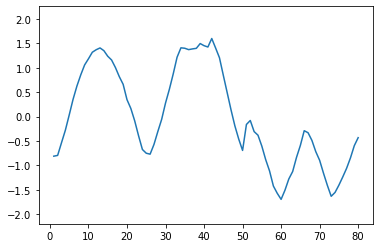

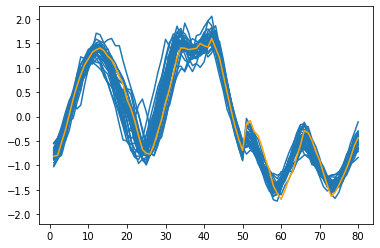

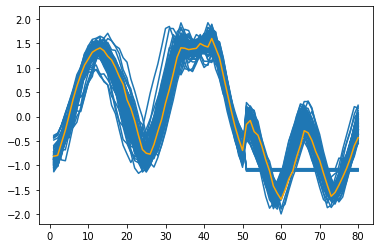

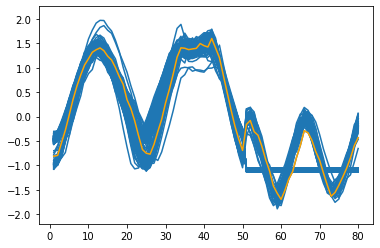


Original Adversarial Sample: Input Sample [8]
RNN Output: tensor([-2.6205,  1.1432,  0.8401], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 3.5447e-08, 8.8931e-07], dtype=torch.float64)
Correct Lable: 2.0


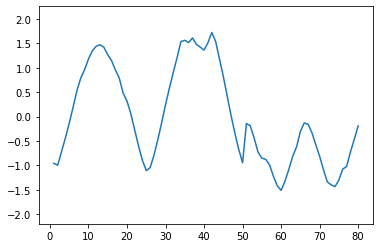

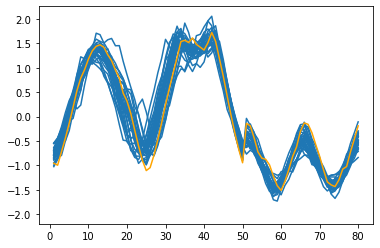

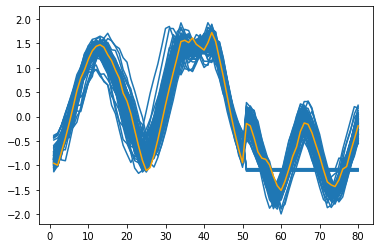

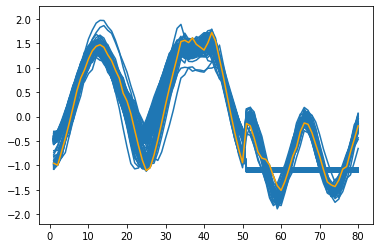


Original Adversarial Sample: Input Sample [11]
RNN Output: tensor([-3.0366,  1.2175,  1.1177], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 1.1389e-12, 2.0031e-11], dtype=torch.float64)
Correct Lable: 2.0


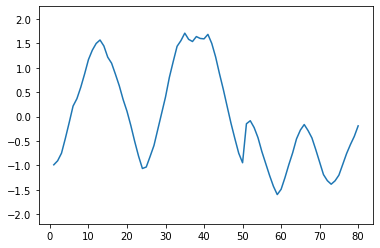

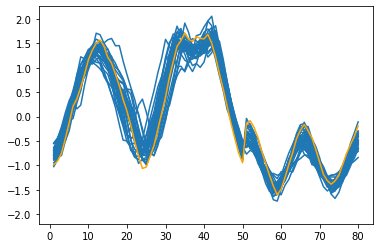

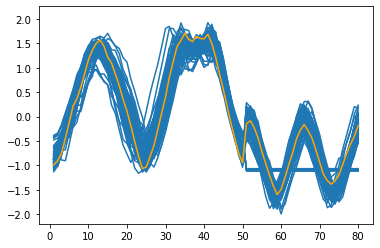

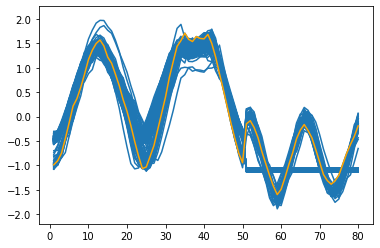


Original Adversarial Sample: Input Sample [20]
RNN Output: tensor([-3.4496,  1.3968,  1.3450], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 3.5801e-07, 4.8346e-06], dtype=torch.float64)
Correct Lable: 2.0


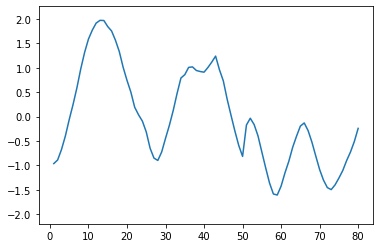

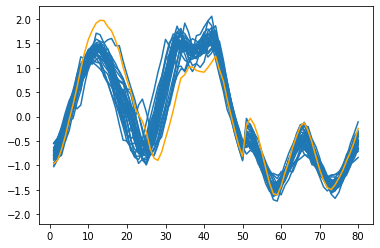

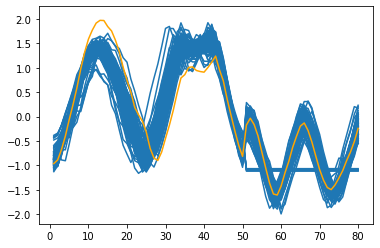

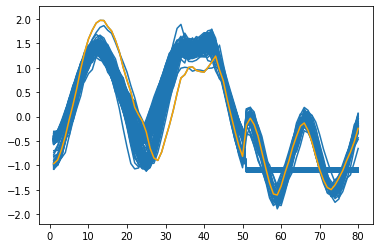


Original Adversarial Sample: Input Sample [24]
RNN Output: tensor([-2.8101,  1.6261,  0.8306], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 2.1845e-09, 1.1310e-08], dtype=torch.float64)
Correct Lable: 2.0


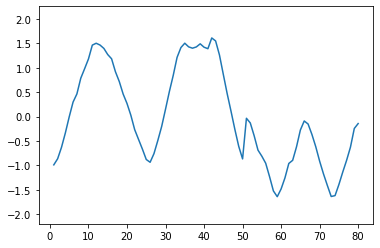

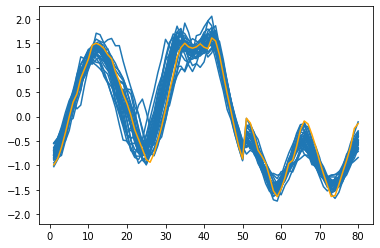

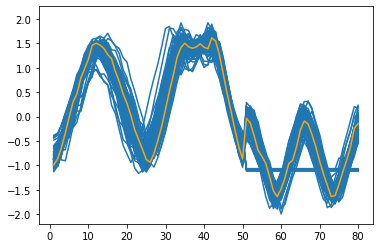

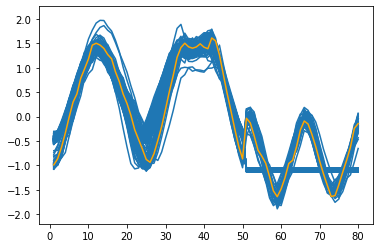


Original Adversarial Sample: Input Sample [37]
RNN Output: tensor([-2.1708,  1.4059,  0.4564], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 2.4727e-09, 1.9782e-08], dtype=torch.float64)
Correct Lable: 2.0


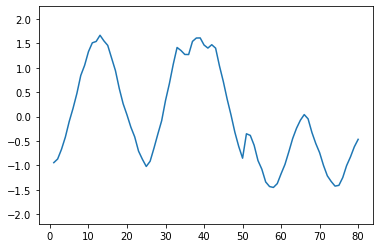

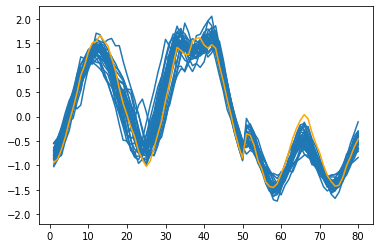

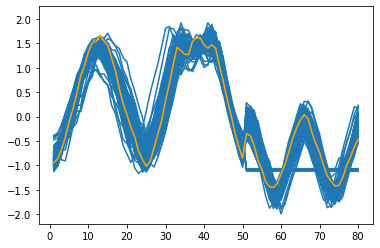

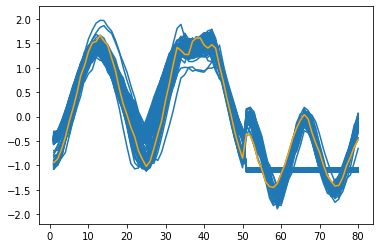


Original Adversarial Sample: Input Sample [38]
RNN Output: tensor([-4.5674,  2.2374,  1.8233], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 1.8258e-07, 5.4774e-07], dtype=torch.float64)
Correct Lable: 2.0


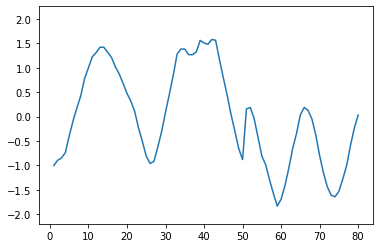

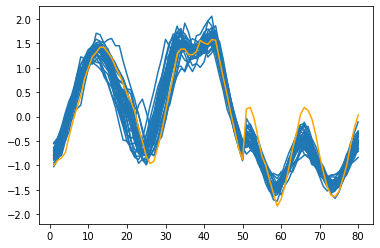

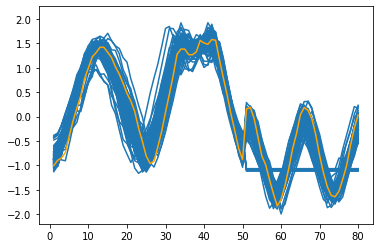

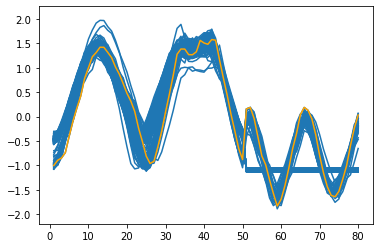


Original Adversarial Sample: Input Sample [64]
RNN Output: tensor([-4.2892,  2.3166,  1.6179], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 4.0518e-10, 7.6983e-09], dtype=torch.float64)
Correct Lable: 2.0


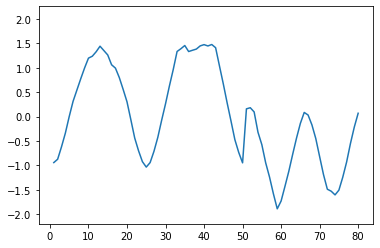

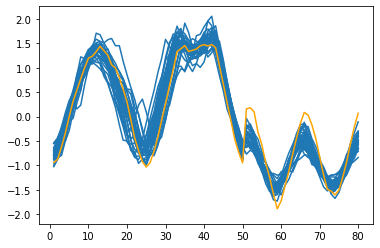

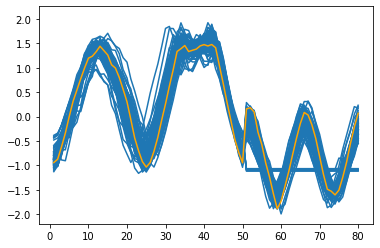

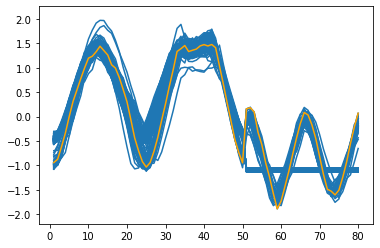


Original Adversarial Sample: Input Sample [76]
RNN Output: tensor([-1.0575,  1.7812, -0.5041], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 1.7381e-10, 3.4761e-10], dtype=torch.float64)
Correct Lable: 2.0


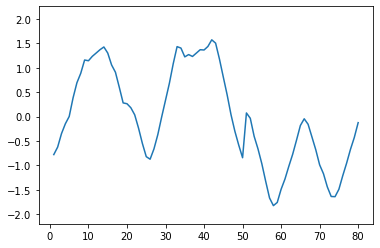

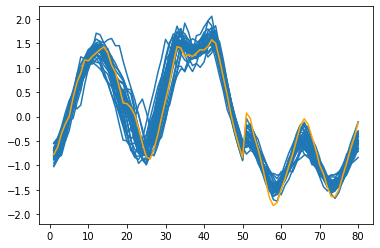

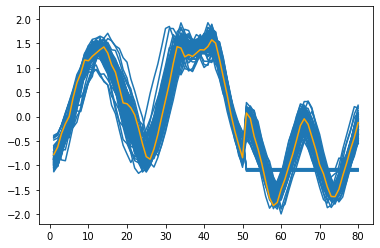

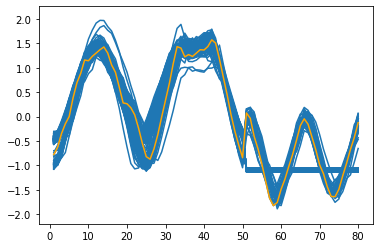


Original Adversarial Sample: Input Sample [84]
RNN Output: tensor([-3.8441,  2.0463,  1.4049], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 1.2111e-05, 2.4465e-05], dtype=torch.float64)
Correct Lable: 2.0


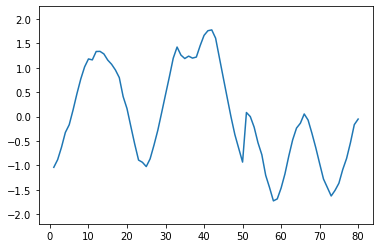

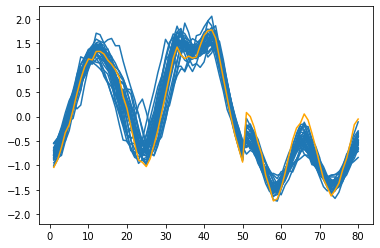

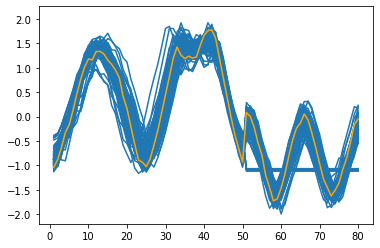

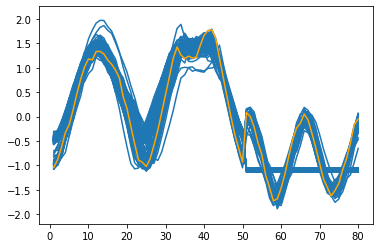


Original Adversarial Sample: Input Sample [101]
RNN Output: tensor([-1.8874,  1.1538,  0.3287], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 1.1582e-05, 5.5722e-05], dtype=torch.float64)
Correct Lable: 2.0


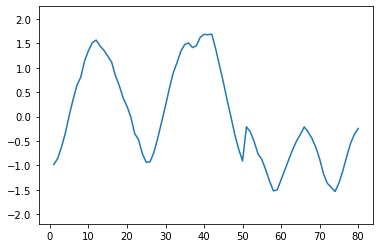

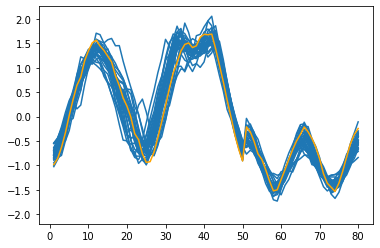

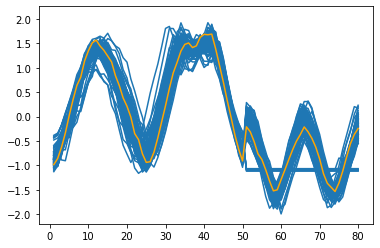

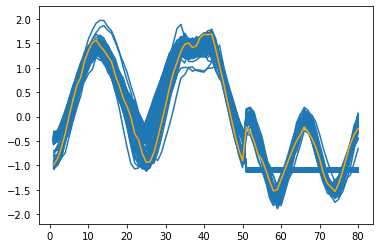


Original Adversarial Sample: Input Sample [127]
RNN Output: tensor([-1.3212,  1.4235, -0.1390], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 1.0144e-09, 4.0578e-09], dtype=torch.float64)
Correct Lable: 2.0


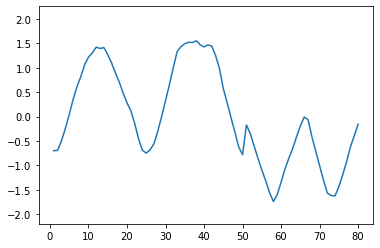

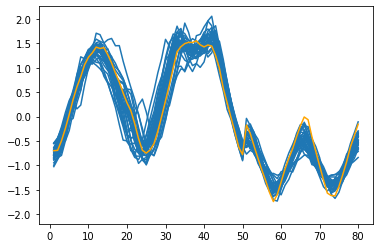

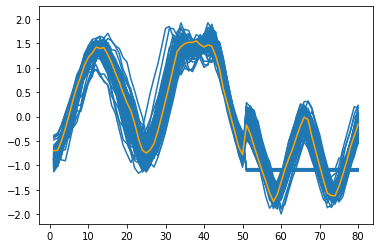

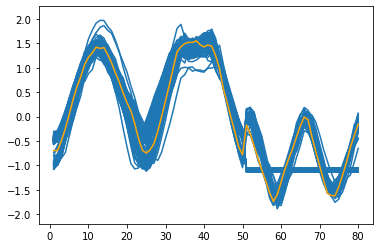


Original Adversarial Sample: Input Sample [144]
RNN Output: tensor([-3.4612,  1.3881,  1.3617], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 1.1590e-08, 5.2156e-08], dtype=torch.float64)
Correct Lable: 2.0


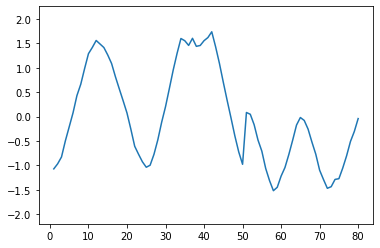

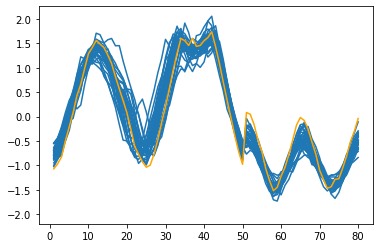

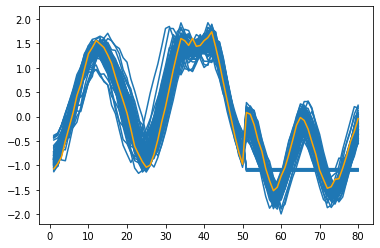

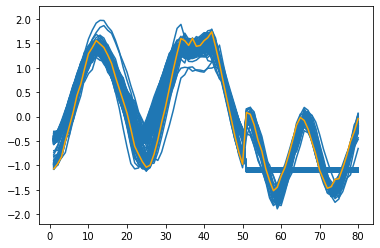


Original Adversarial Sample: Input Sample [145]
RNN Output: tensor([-4.2214,  2.2981,  1.5898], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 3.5549e-09, 2.1330e-08], dtype=torch.float64)
Correct Lable: 2.0


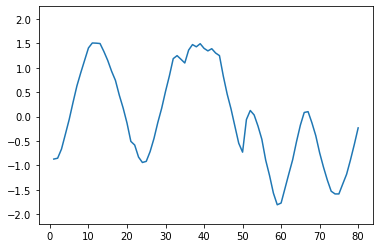

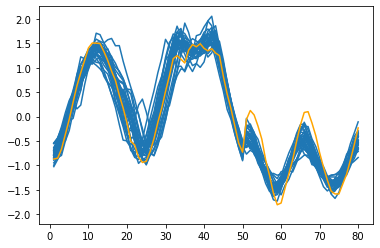

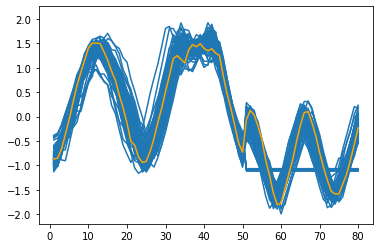

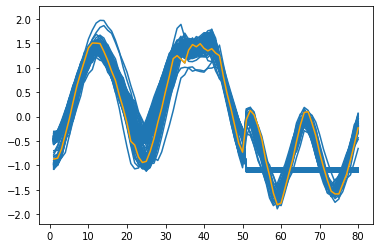


Original Adversarial Sample: Input Sample [147]
RNN Output: tensor([-2.2900,  1.5497,  0.5026], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 3.2869e-08, 2.1365e-07], dtype=torch.float64)
Correct Lable: 2.0


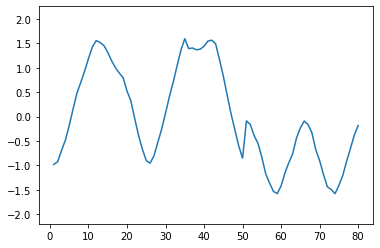

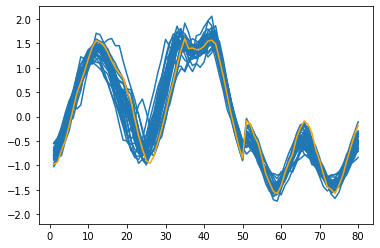

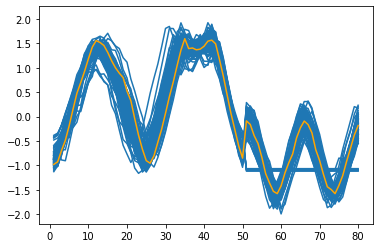

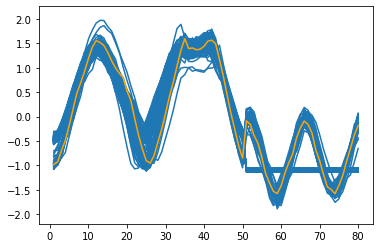


Original Adversarial Sample: Input Sample [382]
RNN Output: tensor([-3.2028,  2.0836,  1.0072], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 1.2466e-09, 3.7397e-09], dtype=torch.float64)
Correct Lable: 2.0


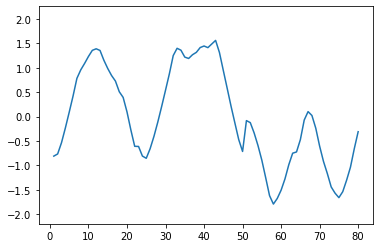

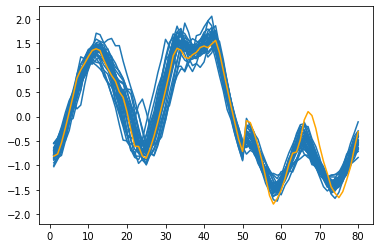

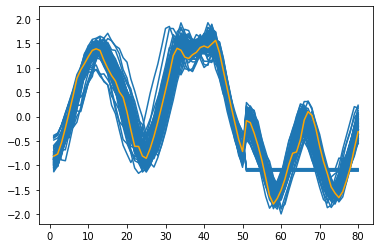

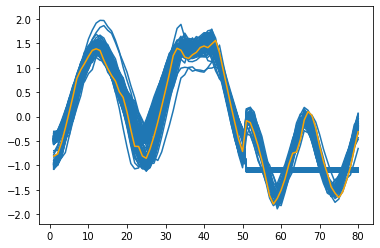


Original Adversarial Sample: Input Sample [383]
RNN Output: tensor([-4.3333,  2.2792,  1.6643], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 3.5951e-08, 2.5100e-07], dtype=torch.float64)
Correct Lable: 2.0


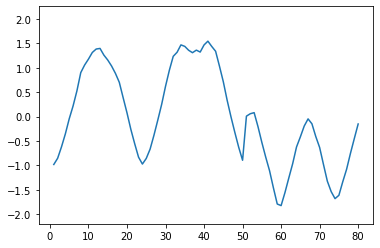

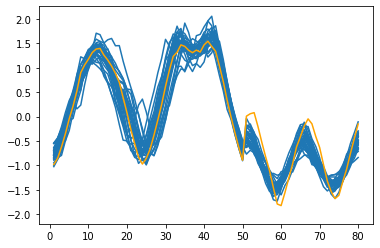

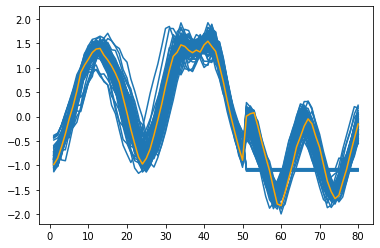

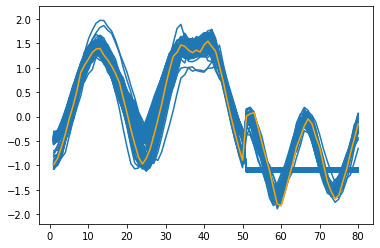


Original Adversarial Sample: Input Sample [384]
RNN Output: tensor([-4.6219,  1.9785,  1.9571], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 5.0762e-08, 1.5229e-07], dtype=torch.float64)
Correct Lable: 2.0


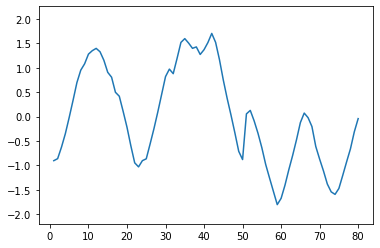

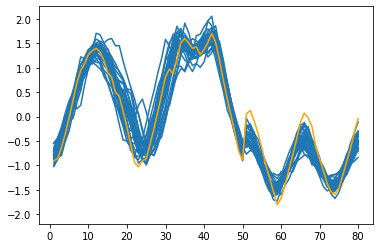

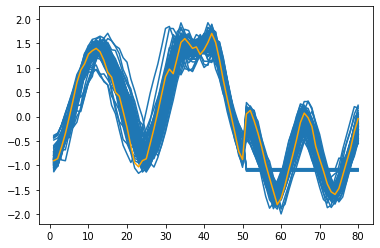

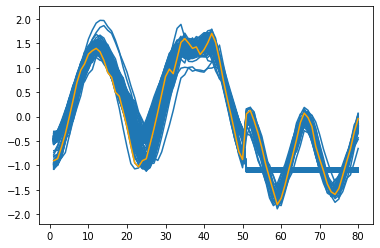


Original Adversarial Sample: Input Sample [387]
RNN Output: tensor([-3.2689,  1.3791,  1.2212], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0000e+00, 1.1339e-09, 1.2473e-08], dtype=torch.float64)
Correct Lable: 2.0


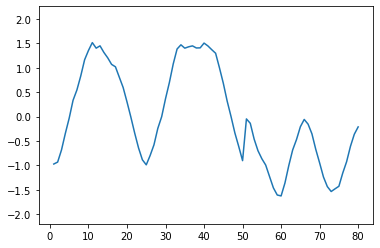

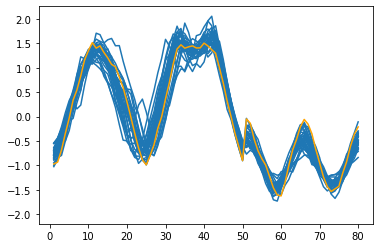

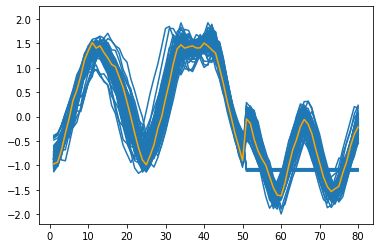

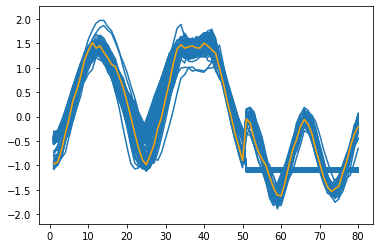

In [5]:
"""
Finding Original Adversarial Samples

"""

ylim_low = 65535  # calculate the range of the plotted figure
ylim_high = 0
for item in train_X:
    for ts in range(TIME_STEP):
        if item[ts, 0] > ylim_high:
            ylim_high = item[ts, 0]
        if item[ts, 0] < ylim_low:
            ylim_low = item[ts, 0]
input_distance = ylim_high - ylim_low
plot_distance = (input_distance) / 10  # calculate the plot distance under the dataset

timestep_record = [i for i in range(1, TIME_STEP+1)]
for i in differ_record:
    if rnn_pred_train_y[i] != train_Y[i] and wfa_pred_train_y[i] == train_Y[i]:        
        print(f'\nOriginal Adversarial Sample: Input Sample [{i}]')
#         print(train_X[i])
        print(f'RNN Output: {rnn_output[i, :]}')
        print(f'WFA Output: {wfa_output[i, :]}')
        print(f'Correct Lable: {train_Y[i]}')
        
        adv_X_record = []  # plot current original adversarial sample
        for item in np.array(train_X[i]):
            adv_X_record.append(item[0])
        plt.plot(timestep_record, adv_X_record)
        plt.ylim((ylim_low-plot_distance/2, ylim_high+plot_distance/2))
        plt.show()
     
        for j in range(OUTPUT_SIZE):  # plot all the classes as reference objects respectively
            for k in range(train_X.shape[0]):
                if train_Y[k] == j:
                    X_record = []
                    for item in np.array(train_X[k]):
                        X_record.append(item[0]) 
                    plt.plot(timestep_record, X_record, color='#1f77b4')
            plt.plot(timestep_record, adv_X_record, color='orange')
            plt.ylim((ylim_low-plot_distance/2, ylim_high+plot_distance/2))
            plt.show()


In [ ]:
"""
Adversarial Samples Generation

"""

# ----- Set Hyper-parameter of Perturbation ----- #

SAMPLING_GRAIN = 10  # sampling grain size for each iteration, do not need to change normally

PERTURBATION_FACTOR = 0.5  # value range: (0,1], bigger value means larger perturbation under the limitation of 'micro'
PERTURBATION_WINDOW_FACTOR = 0.5  # value range: (0,1], bigger value means larger window size under the limitation of 'micro'

perturbation_range = PERTURBATION_FACTOR * (average_distance / 10)
perturbation_window_size = int(PERTURBATION_WINDOW_FACTOR * (TIME_STEP / 10))


# ----- Finding Minimum Positive Sample ----- #

original_adv_X_set = []
parent_adv_X_set = []
parent_adv_Y_set = []

for i in differ_record:
    if rnn_pred_train_y[i] != train_Y[i] and wfa_pred_train_y[i] == train_Y[i]:
        print("==========", i)
        abst_bias = []
        for k in range(train_X.shape[0]):
            current_abst_bias = 0
            for j in range(train_X.shape[1]):
                current_abst_bias += abs(int(abst_alphabet_labels[k,j])-int(abst_alphabet_labels[i,j]))
            abst_bias.append(current_abst_bias)
        candidate_samples_index = np.argsort(abst_bias)
        
        ### 可以多取几个
        for candidate_sample_index in candidate_samples_index:
            if rnn_pred_train_y[candidate_sample_index] != train_Y[candidate_sample_index] or train_Y[candidate_sample_index] != train_Y[i]:
                continue
            
            minimum_positive_sample = train_X[candidate_sample_index]
            current_negative_X = copy.deepcopy(np.array(train_X[i]))
#             print(candidate_sample_index)
#             print(minimum_positive_sample)
#             print(current_negative_X)
            
            # iterative sampling in variable pos-neg range
            while True:
                sampled_instant_X_set = []
                sampled_instant_Y_set = []

                # build sampler
                sampling_bias_x = []
                for j in range(train_X.shape[1]):
                    sampling_bias_x_2 = []
                    for k in range(train_X.shape[2]):
                        real_bias = minimum_positive_sample[j,k] - current_negative_X[j,k]
                        sampling_bias = real_bias / SAMPLING_GRAIN
                        sampling_bias_x_2.append(sampling_bias)   
                    sampling_bias_x.append(sampling_bias_x_2)
                sampling_bias_x = np.array(sampling_bias_x)
#                 print(sampling_bias_x)
            
                # sampling
                sampled_instant_X = copy.deepcopy(current_negative_X)
                for j in range(SAMPLING_GRAIN+1):
                    sampled_instant_X_set.append(copy.deepcopy(sampled_instant_X))
                    sampled_instant_Y_set.append(train_Y[i])
                    sampled_instant_X += sampling_bias_x
#                 print(sampled_instant_X_set)

                # find pos and neg distrubution
                sampled_instant_X_set = np.array(sampled_instant_X_set)
                sampled_instant_Y_set = np.array(sampled_instant_Y_set)
                sampled_instant_X_set = torch.from_numpy(sampled_instant_X_set).to(torch.float32)
                sampled_instant_output, _ = rnn(sampled_instant_X_set)
                pred_sampled_instant_y = torch.max(sampled_instant_output, 1)[1].data.numpy()
                sampled_instant_acc_record = (pred_sampled_instant_y == sampled_instant_Y_set)
                
                # update pos-neg range
                for j in range(len(sampled_instant_acc_record)-1):
                    print(sampled_instant_acc_record[j])
                    if not sampled_instant_acc_record[j] and sampled_instant_acc_record[j+1]:
                        current_negative_X = copy.deepcopy(np.array(sampled_instant_X_set[j]))
                        minimum_positive_sample = copy.deepcopy(np.array(sampled_instant_X_set[j+1]))
                    
                # end condition
                end_flag = True
                for j in range(train_X.shape[2]):
                    if sampling_bias_x[:, j].max() > perturbation_range[j] / 10:  # 停止条件取 perturbation_range 的多少合适？
                        end_flag = False
                if end_flag:  
                    original_adv_X_set.append(train_X[candidate_sample_index])
                    parent_adv_X_set.append(minimum_positive_sample)
                    parent_adv_Y_set.append(train_Y[i])
                    break
            
            break
        
           
# ----- Adversarial Samples Generation ----- #

adv_X_set = []
adv_Y_set = []        

for i in range(len(parent_adv_X_set)):
    parent_adv_X = parent_adv_X_set[i]
    parent_adv_Y = parent_adv_Y_set[i]
    
    adv_X = []
    for j in range(TIME_STEP-perturbation_window_size+1):
        current_adv_X_1 = copy.deepcopy(parent_adv_X)
        current_adv_X_2 = copy.deepcopy(parent_adv_X)

        for k in range(perturbation_window_size):
            for t in range(train_X.shape[2]):  # perturbation distance is different for each feature (dimensionality)
                current_adv_X_1[j+k][t] -= perturbation_range[t]
                current_adv_X_2[j+k][t] += perturbation_range[t]  # two perturbation method + and -
        
        adv_X.append(np.array(current_adv_X_1))
        adv_X.append(np.array(current_adv_X_2))

    adv_Y = [parent_adv_Y for j in range(len(adv_X))]

    adv_X_set.extend(adv_X)
    adv_Y_set.extend(adv_Y)

    single_adv_X_set_len = len(adv_X)

print(f'The Number of Adversarial Samples Generated: {len(adv_X_set)}')
np.save(f"buffer_adv_X_set.npy", adv_X_set)
np.save(f"buffer_adv_Y_set.npy", adv_Y_set)


# ----- Adversarial Attack Evaluation and Illustration----- #

if not adv_X_set:
    print('Success Rate of Adversarial Attack: 0 %')
else:
#     whole_adv_X_set = copy.deepcopy(adv_X_set)
#     adv_X_set = []
#     for i in range(int(len(whole_adv_X_set)/500):
#         if i == 
    
    
    adv_X_set = np.array(adv_X_set)
    adv_Y_set = np.array(adv_Y_set)
    adv_X_set = torch.from_numpy(adv_X_set).to(torch.float32)
    adv_output, _ = rnn(adv_X_set)
    pred_adv_y = torch.max(adv_output, 1)[1].data.numpy()
    adv_accuracy = float((pred_adv_y == adv_Y_set).astype(int).sum()) / float(adv_Y_set.size)
    print('Success Rate of Adversarial Attack: %.2f' % ((1-adv_accuracy)*100), '%')
    
    test_acc_num = (pred_test_y == test_Y).astype(int).sum()
    adv_acc_num = (pred_adv_y == adv_Y_set).astype(int).sum()
    test_adv_total_num = test_Y.size + adv_Y_set.size
    attacked_test_accuracy = float(test_acc_num + adv_acc_num) / float(test_adv_total_num)
    print('Attacked RNN Test Accuracy: %.6f' % attacked_test_accuracy)

    for i in range(len(parent_adv_X_set)):
        for j in range(i*single_adv_X_set_len, (i+1)*single_adv_X_set_len):  # for every adversarial samples generated under an original adv X
            if pred_adv_y[j] != adv_Y_set[j]:
                for k in range(train_X.shape[0]):  # samples in train X who have the same correct label of the original adv X
                    if train_Y[k] == adv_Y_set[i*single_adv_X_set_len]:
                        X_record = []
                        for item in np.array(train_X[k]):
                            X_record.append(item[0]) 
                        plt.plot(timestep_record, X_record, color='#1f77b4')#np.array(train_X[i])

                plt.plot(timestep_record, original_adv_X_set[i], color='purple')  # the specific original adv X as reference object
                plt.plot(timestep_record, adv_X_set[j], color='red')
                plt.plot(timestep_record, parent_adv_X_set[i], color='orange')  # the specific original adv X as reference object
                plt.ylim((ylim_low-plot_distance/2, ylim_high+plot_distance/2))
                plt.show()
                
### + 专家评估

In [5]:
rnn = torch.load(f'../Models/{NAME}/epoch_199_0.pkl')
test_output, _ = rnn(test_X)
pred_test_y = torch.max(test_output, 1)[1].data.numpy()
adv_X_set = np.load(f"buffer_adv_X_set.npy")
adv_Y_set = np.load(f"buffer_adv_Y_set.npy")
print(len(adv_X_set))

adv_X_set = np.array(adv_X_set)
adv_Y_set = np.array(adv_Y_set)
adv_X_set = torch.from_numpy(adv_X_set).to(torch.float32)
adv_output, _ = rnn(adv_X_set)
pred_adv_y = torch.max(adv_output, 1)[1].data.numpy()
adv_accuracy = float((pred_adv_y == adv_Y_set).astype(int).sum()) / float(adv_Y_set.size)
print('Success Rate of Adversarial Attack: %.2f' % ((1-adv_accuracy)*100), '%')

test_acc_num = (pred_test_y == test_Y).astype(int).sum()
adv_acc_num = (pred_adv_y == adv_Y_set).astype(int).sum()
test_adv_total_num = test_Y.size + adv_Y_set.size
attacked_test_accuracy = float(test_acc_num + adv_acc_num) / float(test_adv_total_num)
print('Attacked RNN Test Accuracy: %.6f' % attacked_test_accuracy)

for i in range(len(parent_adv_X_set)):
    for j in range(i*single_adv_X_set_len, (i+1)*single_adv_X_set_len):  # for every adversarial samples generated under an original adv X
        if pred_adv_y[j] != adv_Y_set[j]:
            for k in range(train_X.shape[0]):  # samples in train X who have the same correct label of the original adv X
                if train_Y[k] == adv_Y_set[i*single_adv_X_set_len]:
                    X_record = []
                    for item in np.array(train_X[k]):
                        X_record.append(item[0]) 
                    plt.plot(timestep_record, X_record, color='#1f77b4')#np.array(train_X[i])

            plt.plot(timestep_record, original_adv_X_set[i], color='purple')  # the specific original adv X as reference object
            plt.plot(timestep_record, adv_X_set[j], color='red')
            plt.plot(timestep_record, parent_adv_X_set[i], color='orange')  # the specific original adv X as reference object
            plt.ylim((ylim_low-plot_distance/2, ylim_high+plot_distance/2))
            plt.show()
                
### + 专家评估

2926
Success Rate of Adversarial Attack: 32.02 %
Attacked RNN Test Accuracy: 0.684502


In [7]:
import csv

adv_X_set = np.array(adv_X_set)
adv_Y_set = np.array(adv_Y_set)

with open(f'../UCR-Adv/{dataset}-Adv.tsv', 'w', newline='') as f:
    tsv_w = csv.writer(f, delimiter='\t')
    for i in range(adv_X_set.shape[0]):
        current_row = [adv_Y_set[i] for k in range(adv_X_set.shape[1]+1)]
        for j in range(adv_X_set.shape[1]):
            current_row[j+1] = adv_X_set[i, j, 0]
        tsv_w.writerow(current_row)  
